In [2]:
!nvidia-smi

Mon Apr 11 11:51:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           Off  | 00000000:02:00.0 Off |                    0 |
| N/A   36C    P0    61W / 250W |    115MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           Off  | 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0    60W / 250W |  11026MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import os
import matplotlib
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt
from datatools import Loader2D, Generator, show_xy, Aug2D
from traintools import plot_history, get_callbacks, create_dirs

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = "/media/hdd/public/Datasets/faces/300W"
imsize = (64, 64)
used_lmarks = []
for i in [8, 30, 36, 39, 42, 45, 48, 54]:
    used_lmarks += list(range(i*2, i*2+2))

In [4]:
loader_train = Loader2D(data_dir=os.path.join(data_dir, "train_crop"), 
                        img_size=imsize, 
                        valid_size=0, 
                        annotation_file="annotations.txt",
                        augmenter=Aug2D(imsize),
                        used_lmarks=used_lmarks
                       )   
loader_valid = Loader2D(data_dir=os.path.join(data_dir, "test_crop"), 
                        img_size=imsize, 
                        valid_size=1, 
                        annotation_file="annotations.txt",
                        augmenter=Aug2D(imsize),
                        used_lmarks=used_lmarks
                       )  

In [5]:
# Test generator
n = 0
for x, y in Generator(loader_train, 8).get_iterator(train=True):
    n += 1
    print(x.shape, y.shape)
    if n >= 3:
        break

(8, 64, 64, 1) (8, 16)
(8, 64, 64, 1) (8, 16)
(8, 64, 64, 1) (8, 16)


0.0 255.0


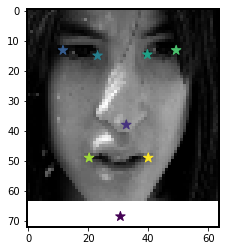

In [22]:
x, y = loader_train.get_item(loader_train.train_set[np.random.randint(100)])
show_xy(x, y)
print(x.min(), x.max())

In [26]:
from models import vanilla, fconv2d

model = vanilla((imsize[1], imsize[0], 1))
model.load_weights("vanilla-68/checkpoints/model_final.h5")
print(model.summary(100))

Model: "landmarks-vanilla2d"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
data (InputLayer)                            [(None, 64, 64, 1)]                     0              
____________________________________________________________________________________________________
lambda (Lambda)                              (None, 64, 64, 1)                       0              
____________________________________________________________________________________________________
conv_block_01_conv (Conv2D)                  (None, 64, 64, 16)                      416            
____________________________________________________________________________________________________
conv_block_01_act (Activation)               (None, 64, 64, 16)                      0              
______________________________________________________________

In [27]:
from tensorflow.keras import optimizers
logdir = create_dirs("vanilla-68/")

model.compile(loss="mean_absolute_error", optimizer=optimizers.Adam())

In [11]:
gen_train = Generator(loader_train, 128)
gen_valid = Generator(loader_valid, 128)

In [12]:
history = model.fit_generator(generator=gen_train.get_iterator(train=True),
                              steps_per_epoch=20,
                              epochs=400,
                              initial_epoch=0,
                              validation_data=gen_valid.get_iterator(train=False),
                              validation_steps=25,
                              callbacks=get_callbacks(logdir, 0.002, 350),
                              use_multiprocessing=False
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
20/20 [==============================] - ETA: 0s - loss: 0.2679
Epoch 00001: val_loss improved from inf to 0.11355, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 25s 1s/step - loss: 0.2679 - val_loss: 0.1135 - lr: 0.0020
Epoch 2/400
20/20 [==============================] - ETA: 0s - loss: 0.1076
Epoch 00002: val_loss improved from 0.11355 to 0.07464, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 26s 1s/step - loss: 0.1076 - val_loss: 0.0746 - lr: 0.0020
Epoch 3/400
20/20 [==============================] - ETA: 0s - loss: 0.0847
Epoch 00003: val_loss improved from 0.07464 to 0.06831, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 25s 1s/step - loss: 0.0847 - val_loss: 0.0683 - lr: 0.0020
Epoch 4/400
20/20 [==============================] - ETA: 0s - l

Epoch 31/400
20/20 [==============================] - ETA: 0s - loss: 0.0255
Epoch 00031: val_loss improved from 0.02800 to 0.02579, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 26s 1s/step - loss: 0.0255 - val_loss: 0.0258 - lr: 0.0020
Epoch 32/400
20/20 [==============================] - ETA: 0s - loss: 0.0260
Epoch 00032: val_loss did not improve from 0.02579
20/20 [==============================] - 26s 1s/step - loss: 0.0260 - val_loss: 0.0266 - lr: 0.0020
Epoch 33/400
20/20 [==============================] - ETA: 0s - loss: 0.0248
Epoch 00033: val_loss did not improve from 0.02579
20/20 [==============================] - 24s 1s/step - loss: 0.0248 - val_loss: 0.0265 - lr: 0.0020
Epoch 34/400
20/20 [==============================] - ETA: 0s - loss: 0.0247
Epoch 00034: val_loss improved from 0.02579 to 0.02432, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 26s 1s/step - loss: 0.024

Epoch 65/400
20/20 [==============================] - ETA: 0s - loss: 0.0203
Epoch 00065: val_loss improved from 0.02069 to 0.02030, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 24s 1s/step - loss: 0.0203 - val_loss: 0.0203 - lr: 0.0020
Epoch 66/400
20/20 [==============================] - ETA: 0s - loss: 0.0200
Epoch 00066: val_loss did not improve from 0.02030
20/20 [==============================] - 25s 1s/step - loss: 0.0200 - val_loss: 0.0206 - lr: 0.0020
Epoch 67/400
20/20 [==============================] - ETA: 0s - loss: 0.0195
Epoch 00067: val_loss improved from 0.02030 to 0.01998, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 25s 1s/step - loss: 0.0195 - val_loss: 0.0200 - lr: 0.0020
Epoch 68/400
20/20 [==============================] - ETA: 0s - loss: 0.0199
Epoch 00068: val_loss did not improve from 0.01998
20/20 [==============================] - 26s 1s/step - loss: 0.019

Epoch 99/400
20/20 [==============================] - ETA: 0s - loss: 0.0177
Epoch 00099: val_loss did not improve from 0.01798
20/20 [==============================] - 26s 1s/step - loss: 0.0177 - val_loss: 0.0192 - lr: 0.0020
Epoch 100/400
20/20 [==============================] - ETA: 0s - loss: 0.0181
Epoch 00100: val_loss did not improve from 0.01798
20/20 [==============================] - 26s 1s/step - loss: 0.0181 - val_loss: 0.0202 - lr: 0.0020
Epoch 101/400
20/20 [==============================] - ETA: 0s - loss: 0.0182
Epoch 00101: val_loss did not improve from 0.01798
20/20 [==============================] - 26s 1s/step - loss: 0.0182 - val_loss: 0.0202 - lr: 0.0020
Epoch 102/400
20/20 [==============================] - ETA: 0s - loss: 0.0179
Epoch 00102: val_loss improved from 0.01798 to 0.01770, saving model to ./fconv2d-8-scaled/checkpoints/model.h5
20/20 [==============================] - 26s 1s/step - loss: 0.0179 - val_loss: 0.0177 - lr: 0.0020
Epoch 103/400
20/20 [===

Epoch 134/400
20/20 [==============================] - ETA: 0s - loss: 0.0161
Epoch 00134: val_loss did not improve from 0.01654
20/20 [==============================] - 27s 1s/step - loss: 0.0161 - val_loss: 0.0177 - lr: 0.0020
Epoch 135/400
20/20 [==============================] - ETA: 0s - loss: 0.0164
Epoch 00135: val_loss did not improve from 0.01654
20/20 [==============================] - 27s 1s/step - loss: 0.0164 - val_loss: 0.0172 - lr: 0.0020
Epoch 136/400
20/20 [==============================] - ETA: 0s - loss: 0.0162
Epoch 00136: val_loss did not improve from 0.01654
20/20 [==============================] - 26s 1s/step - loss: 0.0162 - val_loss: 0.0186 - lr: 0.0020
Epoch 137/400
20/20 [==============================] - ETA: 0s - loss: 0.0167
Epoch 00137: val_loss did not improve from 0.01654
20/20 [==============================] - 26s 1s/step - loss: 0.0167 - val_loss: 0.0176 - lr: 0.0020
Epoch 138/400
20/20 [==============================] - ETA: 0s - loss: 0.0164
Epoch 

20/20 [==============================] - ETA: 0s - loss: 0.0156
Epoch 00169: val_loss did not improve from 0.01617
20/20 [==============================] - 26s 1s/step - loss: 0.0156 - val_loss: 0.0169 - lr: 0.0020
Epoch 170/400
20/20 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00170: val_loss did not improve from 0.01617
20/20 [==============================] - 25s 1s/step - loss: 0.0157 - val_loss: 0.0172 - lr: 0.0020
Epoch 171/400
20/20 [==============================] - ETA: 0s - loss: 0.0154
Epoch 00171: val_loss did not improve from 0.01617
20/20 [==============================] - 26s 1s/step - loss: 0.0154 - val_loss: 0.0171 - lr: 0.0020
Epoch 172/400
20/20 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00172: val_loss did not improve from 0.01617
20/20 [==============================] - 26s 1s/step - loss: 0.0157 - val_loss: 0.0164 - lr: 0.0020
Epoch 173/400
20/20 [==============================] - ETA: 0s - loss: 0.0153
Epoch 00173: val_los

20/20 [==============================] - ETA: 0s - loss: 0.0150
Epoch 00204: val_loss did not improve from 0.01573
20/20 [==============================] - 26s 1s/step - loss: 0.0150 - val_loss: 0.0161 - lr: 0.0020
Epoch 205/400
20/20 [==============================] - ETA: 0s - loss: 0.0149
Epoch 00205: val_loss did not improve from 0.01573
20/20 [==============================] - 27s 1s/step - loss: 0.0149 - val_loss: 0.0161 - lr: 0.0020
Epoch 206/400
20/20 [==============================] - ETA: 0s - loss: 0.0154
Epoch 00206: val_loss did not improve from 0.01573
20/20 [==============================] - 25s 1s/step - loss: 0.0154 - val_loss: 0.0161 - lr: 0.0020
Epoch 207/400
20/20 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00207: val_loss did not improve from 0.01573
20/20 [==============================] - 26s 1s/step - loss: 0.0155 - val_loss: 0.0187 - lr: 0.0020
Epoch 208/400
20/20 [==============================] - ETA: 0s - loss: 0.0150
Epoch 00208: val_los

Epoch 240/400
20/20 [==============================] - ETA: 0s - loss: 0.0146
Epoch 00240: val_loss did not improve from 0.01538
20/20 [==============================] - 26s 1s/step - loss: 0.0146 - val_loss: 0.0155 - lr: 0.0020
Epoch 241/400
20/20 [==============================] - ETA: 0s - loss: 0.0148
Epoch 00241: val_loss did not improve from 0.01538
20/20 [==============================] - 26s 1s/step - loss: 0.0148 - val_loss: 0.0177 - lr: 0.0020
Epoch 242/400
20/20 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00242: val_loss did not improve from 0.01538
20/20 [==============================] - 26s 1s/step - loss: 0.0145 - val_loss: 0.0168 - lr: 0.0020
Epoch 243/400
20/20 [==============================] - ETA: 0s - loss: 0.0143
Epoch 00243: val_loss did not improve from 0.01538
20/20 [==============================] - 26s 1s/step - loss: 0.0143 - val_loss: 0.0158 - lr: 0.0020
Epoch 244/400
20/20 [==============================] - ETA: 0s - loss: 0.0143
Epoch 

Epoch 275/400
20/20 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00275: val_loss did not improve from 0.01514
20/20 [==============================] - 26s 1s/step - loss: 0.0145 - val_loss: 0.0160 - lr: 0.0020
Epoch 276/400
20/20 [==============================] - ETA: 0s - loss: 0.0144
Epoch 00276: val_loss did not improve from 0.01514
20/20 [==============================] - 26s 1s/step - loss: 0.0144 - val_loss: 0.0161 - lr: 0.0020
Epoch 277/400
20/20 [==============================] - ETA: 0s - loss: 0.0143
Epoch 00277: val_loss did not improve from 0.01514
20/20 [==============================] - 26s 1s/step - loss: 0.0143 - val_loss: 0.0157 - lr: 0.0020
Epoch 278/400
20/20 [==============================] - ETA: 0s - loss: 0.0141
Epoch 00278: val_loss did not improve from 0.01514
20/20 [==============================] - 26s 1s/step - loss: 0.0141 - val_loss: 0.0152 - lr: 0.0020
Epoch 279/400
20/20 [==============================] - ETA: 0s - loss: 0.0145
Epoch 

20/20 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00310: val_loss did not improve from 0.01487
20/20 [==============================] - 26s 1s/step - loss: 0.0140 - val_loss: 0.0155 - lr: 0.0020
Epoch 311/400
20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00311: val_loss did not improve from 0.01487
20/20 [==============================] - 26s 1s/step - loss: 0.0139 - val_loss: 0.0152 - lr: 0.0020
Epoch 312/400
20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00312: val_loss did not improve from 0.01487
20/20 [==============================] - 26s 1s/step - loss: 0.0139 - val_loss: 0.0163 - lr: 0.0020
Epoch 313/400
20/20 [==============================] - ETA: 0s - loss: 0.0143
Epoch 00313: val_loss did not improve from 0.01487
20/20 [==============================] - 26s 1s/step - loss: 0.0143 - val_loss: 0.0156 - lr: 0.0020
Epoch 314/400
20/20 [==============================] - ETA: 0s - loss: 0.0141
Epoch 00314: val_los

20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00345: val_loss did not improve from 0.01427
20/20 [==============================] - 25s 1s/step - loss: 0.0139 - val_loss: 0.0153 - lr: 0.0020
Epoch 346/400
20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00346: val_loss did not improve from 0.01427
20/20 [==============================] - 25s 1s/step - loss: 0.0139 - val_loss: 0.0156 - lr: 0.0020
Epoch 347/400
20/20 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00347: val_loss did not improve from 0.01427
20/20 [==============================] - 25s 1s/step - loss: 0.0140 - val_loss: 0.0148 - lr: 0.0020
Epoch 348/400
20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00348: val_loss did not improve from 0.01427
20/20 [==============================] - 26s 1s/step - loss: 0.0139 - val_loss: 0.0149 - lr: 0.0020
Epoch 349/400
20/20 [==============================] - ETA: 0s - loss: 0.0137
Epoch 00349: val_los

20/20 [==============================] - ETA: 0s - loss: 0.0121
Epoch 00378: val_loss did not improve from 0.01377
20/20 [==============================] - 26s 1s/step - loss: 0.0121 - val_loss: 0.0138 - lr: 2.0000e-04
Epoch 379/400
20/20 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00379: val_loss did not improve from 0.01377
20/20 [==============================] - 25s 1s/step - loss: 0.0123 - val_loss: 0.0139 - lr: 2.0000e-04
Epoch 380/400
20/20 [==============================] - ETA: 0s - loss: 0.0120
Epoch 00380: val_loss did not improve from 0.01377
20/20 [==============================] - 25s 1s/step - loss: 0.0120 - val_loss: 0.0139 - lr: 2.0000e-04
Epoch 381/400
20/20 [==============================] - ETA: 0s - loss: 0.0122
Epoch 00381: val_loss did not improve from 0.01377
20/20 [==============================] - 26s 1s/step - loss: 0.0122 - val_loss: 0.0140 - lr: 2.0000e-04
Epoch 382/400
20/20 [==============================] - ETA: 0s - loss: 0.0121
Epoc

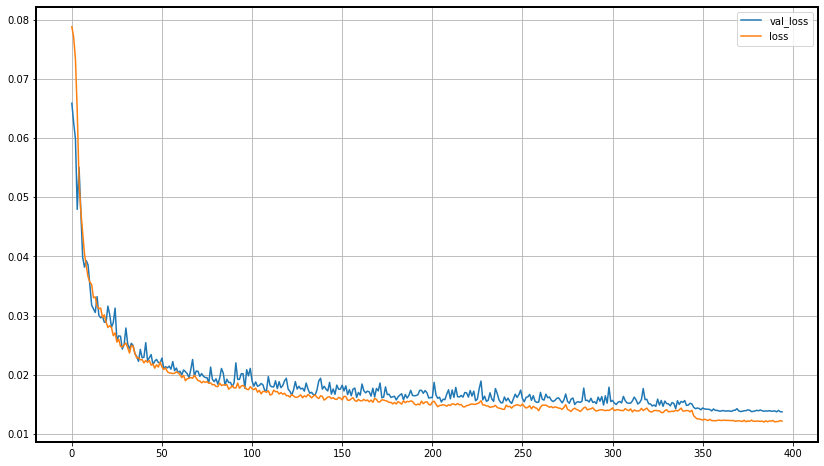

In [28]:
model.save(os.path.join(logdir, "checkpoints", "model_final.h5"))
plot_history(logdir, history)

## Model Validation

In [14]:
%%time
# CALC TEST METRICS WITHOUT AUGMENTATION
gen_test = Generator(loader_valid, 7)
model.evaluate(gen_test.get_iterator(train=False), steps=100)

100/100 [==============================] - 2s 23ms/step - loss: 0.0136
CPU times: user 2.82 s, sys: 156 ms, total: 2.98 s
Wall time: 2.48 s


0.013635175302624702

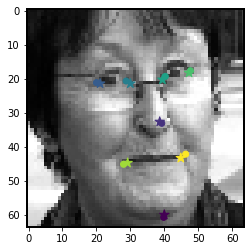

In [15]:
loader_valid.do_augmentation = True
item_id = np.random.randint(100)
x, y = loader_valid.get_item(loader_valid.valid_set[item_id])

lmarks = model.predict(np.expand_dims(x, 0)).flatten()
#print(model.evaluate(np.expand_dims(x, 0), np.expand_dims(y, 0), steps=1, verbose=0))
show_xy(x, y, lmarks)

In [21]:
from testtools import CropTester
def keras_wrapper(img_crop):
    """
    input img_crop: face crop before resize
    output: landmarks as flatten np.array
    """
    net_input = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    net_input = cv2.resize(net_input, model.input_shape[1:-1][::-1])
    net_input = net_input.reshape(1, net_input.shape[0], net_input.shape[1], 1)
    lmarks = model.predict(net_input)
    return lmarks

ct = CropTester(keras_wrapper, num_iterations=5, pad_min_max=(0.0, 0.), crop_type="rand", rseed=1)
#ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/ibug/000385.png")
ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/helen/000022.png", color=(255, 0, 0))

ct.mean_pixel_std()

>>> Output images are placed in ./croptest_out folder


0.0

## Freeze model

In [17]:
model = fconv2d((imsize[1], imsize[0], 1), 8, train_mode=False)
model.load_weights(os.path.join(logdir, "checkpoints/model_final.h5"), by_name=True)
model.save(os.path.join(logdir, "checkpoints/model_infer.h5"))

In [18]:
import subprocess
import sys
subprocess.Popen([r"/bin/bash"])
process_params = [r"{}".format(sys.executable),
                  r"freeze_graph.py",
                  r"{}".format(os.path.join(logdir, "checkpoints/model_infer.h5"))]
res = subprocess.Popen(process_params)

In [14]:
import sys
sys.executable

'/usr/bin/python3.7'

In [18]:
!nvidia-smi

Thu Apr  7 13:52:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           Off  | 00000000:02:00.0 Off |                    0 |
| N/A   34C    P0    61W / 250W |  10880MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           Off  | 00000000:03:00.0 Off |                    0 |
| N/A   35C    P0    60W / 250W |    292MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [19]:
!/usr/bin/python3.7 freeze_graph.py bn_tuning/checkpoints/model_infer.h5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Traceback (most recent call last):
  File "freeze_graph.py", line 58, in <module>
    test_input = np.ones((1,) + model.input.shape[1:])
TypeError: can only concatenate tuple (not "TensorShape") to tuple


In [24]:
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)
print(keras.__version__)
print(sys.executable)

2.2.0
2.3.0-tf
/usr/bin/python3.7
